### Sedaro Results API Example

This notebook exercises funcionality of the Sedaro results API tools. The notebook can be pointed at any scenario branch that has previously been simulated. Examples will step through downloading the data and exploring the results.

In [1]:
import json
from sedaro import SedaroSimulationResult, SedaroAgentResult, SedaroBlockResult, SedaroSeries

#### Important: Read Before Running

This notebook makes changes to agent and scenario branches indicated in the settings section. Ensure any changes to the target branches are saved prior to running this code. Sedaro recommends committing current work and creating new branches in the target repositories to avoid loss of work.

This notebook also requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.

In [2]:
# Settings
with open('./secrets.json', 'r') as file:
    API_KEY = json.load(file)['API_KEY']

# Obtain a scenario ID from the branch table of a particular scenario.
SCENARIO_BRANCH_ID = ...

### Downloading and Navigating Results

The primary entrypoint of the results API is the `SedaroSimulationResult` class. This class offers a few methods for pulling data from scenarios. The most commonly-used method is `.get` that pulls the latest results into a new result object. If the simulation is not complete, the resulting object will indicate the status is "Running" and not contain any results. Alternatively, use the `.poll` method to wait for an in-progress simulation to complete and download results after.

Any object in the results API will provide a descriptive summary of its contents when the `.summarize` method is called.

In [3]:
# Query scenario and do not wait if still running
result = SedaroSimulationResult.get(API_KEY, SCENARIO_BRANCH_ID)

# Query scenario and wait for it to finish
# result = SedaroSimulationResult.poll(API_KEY, SCENARIO_BRANCH_ID)

result.summarize()

---------------------------------------------------------------------------
                      Sedaro Simulation Result Summary                     
---------------------------------------------------------------------------
✅ Simulation succeeded after 431.6s

🛰️ Templated Agents 
    • Starlink-1
    • Starlink-2
    • Starlink-3
    • Starlink-4
    • Starlink-5
    • Starlink-6
    • Starlink-7
    • Starlink-8
    • Starlink-9
    • Starlink-10

📡 Peripheral Agents 
    • GS USA
    • GS Africa
    • GS India
    • GS Australia
---------------------------------------------------------------------------
❓ Query agent results with .agent(<NAME>)


Top-level results are broken down by agent. You can view results for any agent (templated or peripheral) by calling the `.agent` method with the name of an agent listed above. The result class also has helper methods containing lists of the available agents: `.templated_agents` and `peripheral_agents`.

In [4]:
agent_result = result.agent(result.templated_agents[0])
agent_result.summarize()

---------------------------------------------------------------------------
                            Agent Result Summary                           
                                'Starlink-1'                               
---------------------------------------------------------------------------
🧩 Simulated Modules
    • Guidance, Navigation, & Control
    • Power
    • Thermal
    • Command & Data Handling

📦 Available Blocks
    --------------------------------------------------------------------
    |                  id                              name            |
    --------------------------------------------------------------------
    | root                                 |                           |
    | 98                                   | BP Heater                 |
    | 96                                   | 12V Supply                |
    | 95                                   | 12V Supply                |
    | 94                                   | Active

Agent results are organized by blocks, where blocks are the basic elements that make up each simulation. Results for any blocks can be queried by a complete or partial ID, as listed in the ID column above. Note that partial IDs will only return a result if it matches the beginning of only one block ID. The block result class also has a helper attribute, `.blocks`, that returns a list of all block IDs contained in that instance.

There is one special entry in the block list: `root`. This index captures all variables that exist on the lowest level of the simulated agent and do not belong to any block. For example, the agent `position` will usually exist in `root`.

In [5]:
block_result = agent_result.block('root')
block_result.summarize()

---------------------------------------------------------------------------
                   Sedaro Simulation Block Result Summary                  
                                   'root'                                  
---------------------------------------------------------------------------
🧩 Simulated Modules
    • Guidance, Navigation, & Control
    • Power
    • Thermal
    • Command & Data Handling

📋 Variables Available
    • totalMaxSolarPower
    • totalSolarPowerGeneration
    • totalSolarPowerUtilization
    • shadow
    • beta
    • srpTorque
    • dragTorque
    • torque
    • position
    • velocity
    • controlTorque
    • positionSolution
    • velocitySolution
    • orbitalElements
    • perturbationTorque
    • gravityGradientTorque
---------------------------------------------------------------------------
❓ Query variables with .<VARIABLE_NAME>


Block results contain the time histories of state variables associated with that block. State variables can be queried directly through the `.<VARIABLE_NAME>` attribute or the `.variable` method. The `.variables` attribute returns a list of the names of all variables available in the object.

Querying a particular variable returns a time series object.

In [6]:
series = block_result.perturbationTorque
series.summarize()

---------------------------------------------------------------------------
                      Sedaro Simulation Series Summary                     
                            'perturbationTorque'                           
---------------------------------------------------------------------------
📈 805 points covering 94.5 minutes with ~7.0s steps

🗂️ Value data type is 'list'
---------------------------------------------------------------------------
❓ Call .plot to visualize results


Series allow direct access to the data through three attributes:
* `.mjd`: Returns a list of epochs as Modified Julian Dates.
* `.elapsed_time`: Returns a list of elapsed times from the initial epoch in seconds.
* `.values`: Returns a list of state variable values corresponding to the times above.

Alternatively, a series is iterable and can be traversed as shown below.

In [7]:
for elapsed_time, value in series:
    print(elapsed_time, value)
    if elapsed_time > 10:
        break

0.0 [-8.307296026071248e-05, -6.46607309877691e-23, 0.00014479313651166633]
7.922314829193056 [0.002241549454506492, -5.312153275728059e-11, 3.2066004048022087e-10]
15.844625886529684 [0.0022449777804219974, -4.874673994114112e-06, 2.9413719794850576e-05]


Sometimes, a series contains multiple sub-series. This can happen when, for example, multiple frame or unit representations are available for that series. A subseries can be queried through the `.<SERIES_NAME>` attribute and will return a new series.

In [8]:
block_result.position.summarize()

---------------------------------------------------------------------------
                      Sedaro Simulation Series Summary                     
                                 'position'                                
---------------------------------------------------------------------------
📈 805 points covering 94.5 minutes with ~7.0s steps

📑 This series has subseries.

🗂️ Value data types are:
    - 'eci': 'list'
    - 'ecef': 'list'
    - 'llaDeg': 'list'
---------------------------------------------------------------------------
❓ Call .<SUBSERIES_NAME> to select a subseries


In [9]:
block_result.position.ecef.summarize()

---------------------------------------------------------------------------
                      Sedaro Simulation Series Summary                     
                              'position.ecef'                              
---------------------------------------------------------------------------
📈 805 points covering 94.5 minutes with ~7.0s steps

🗂️ Value data type is 'list'
---------------------------------------------------------------------------
❓ Call .plot to visualize results


### Saving and Loading Results Locally

Every Sedaro result object supports saving and restoring results to and from a file. This functionality can be helpful when working with large results to avoid re-downloading the same data. To save data, call the `.to_file` method on any result object. Note that the save operation will return an error if the file already exists.

In [10]:
result.to_file('SimulationResult.bak')

💾 Successfully saved to SimulationResult.bak


Use the `.from_file` class method to load previously-saved results.

In [11]:
new_result = SedaroSimulationResult.from_file('SimulationResult.bak')
new_result.summarize()

---------------------------------------------------------------------------
                      Sedaro Simulation Result Summary                     
---------------------------------------------------------------------------
✅ Simulation succeeded after 431.6s

🛰️ Templated Agents 
    • Starlink-1
    • Starlink-2
    • Starlink-3
    • Starlink-4
    • Starlink-5
    • Starlink-6
    • Starlink-7
    • Starlink-8
    • Starlink-9
    • Starlink-10

📡 Peripheral Agents 
    • GS USA
    • GS Africa
    • GS India
    • GS Australia
---------------------------------------------------------------------------
❓ Query agent results with .agent(<NAME>)


Saving and loading also works for agent, block, and series results using the same methods. Uncomment examples below to try the functionality for different types.

In [12]:
# Saving/loading reference examples

# agent_result.to_file('AgentResult.bak')
# new_agent_result = SedaroAgentResult.from_file('AgentResult.bak')

# block_result.to_file('BlockResult.bak')
# new_block_result = SedaroBlockResult.from_file('BlockResult.bak')

# series.to_file('SeriesResult.bak')
# new_series = SedaroSeries.from_file('SeriesResult.bak')

### Plotting

Series objects also offer some basic plotting functionality for quick visualizations of data through integration with `matplotlib`. If `matplotlib` is not available, the commands below will raise an exception. In some cases, the underlying data is not a plottable data type and the commands below will raise an exception indicating that the operation could not complete.

The `.plot` command accepts arbitrary formatting keyword arguments supported by `matplotlib.pyplot.plot` and will pass them directly to that function.

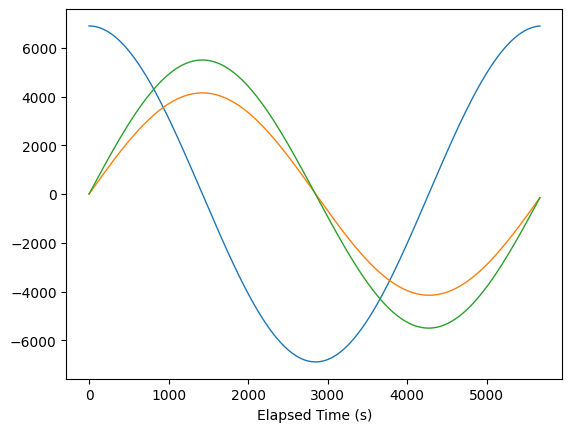

In [13]:
block_result.position.eci.plot(linewidth=1)

An optional keyword argument, `show`, allows for plotting multiple series on the same figure. By default, the `.plot` command will show the figure immediately after plotting. With `show=False`, the plot command will not display the figure until a future command uses `show=True` or the user explicitly calls `matplotlib.pyplot.show()`.

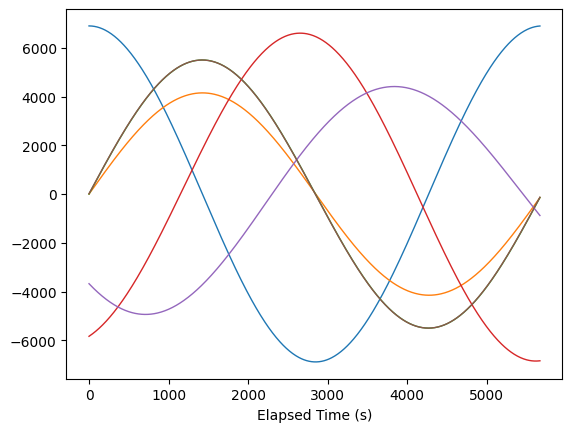

In [14]:
block_result.position.eci.plot(linewidth=1, show=False)
block_result.position.ecef.plot(linewidth=1)